# Actigraphy Processing

Primarily going to use The Euclidean Norm Minus One (ENMO) to determine participant physical activity levels.

CMI used thre `wristpy` package to process the raw actigraphy data initially. You can identify physical activity categories (sedentary, light, moderate, and vigorous) by setting thresholds on the ENMO data, and then we identify time or proportion of time spent in each physical activity category. We will be using the light, moderate, and vigorous thresholds defined by Hildebrand 2014, which is the same as those used in the `wristpy` package. It's important to note these default values are most suited for 7-11 year olds since those were the participants of the study. You can see how `compute_physical_activty_categories` is defined in the `wristpy` package [here](https://github.com/childmindresearch/wristpy/blob/main/src/wristpy/processing/analytics.py).

You can find more information on ENMO [here](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0164045). This paper may contain alternative thresholds we could use.

**Additional work:**
- What should we do about `idle_sleep_mode`?
- We should check the `non-wear_flag` to see if the values are set to 0 and we're inferring sedentary time when we shouldn't.
- We could potentially pull better sleep and physical activity metrics if we use the `wristpy` or a different package in R. I already tried the `pyActigraphy` package, so don't use that. It has package version issues. I tried setting an environment to get teh right pacakge versions, and I tried using it on Colab. Neither worked.
- We would have to deal with non-wear and sleep idle time before we can be certain of any measures we derive. We can double check our derived measures by comparing with survey data at least.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from tqdm import tqdm

In [2]:
# all participant data to loop over
base_dir = 'data/series_train.parquet'
subdirs = os.listdir(base_dir)
pids = [s.replace('id=', '') for s in subdirs]

In [3]:
# get train data to determine who has low/high SII for plots
pids = pd.Series(pids)
train = pd.read_csv('data/train.csv')
train = train[['id', 'sii']]
train[train['id'].isin(pids)]
low_pids = train.loc[train['sii'] == 0, 'id']
hig_pids = train.loc[train['sii'] == 3, 'id']

In [4]:
# functions that can be used for each participant
def read_parquet(pid):
    # Construct the full path to the Parquet file
    file_path = os.path.join(base_dir, 'id='+pid, 'part-0.parquet')
    
    # Read the Parquet file into a DataFrame
    df = pd.read_parquet(file_path)

    # drop non-wear
    df = df[df['non-wear_flag'] == 0]

    return df

def format_time(t):
    # Convert string to integer (assuming it's in nanoseconds)
    nanoseconds = int(t)
    
    # Convert nanoseconds to a timedelta object
    time_delta = datetime.timedelta(microseconds=nanoseconds / 1000)  # Convert nanoseconds to microseconds

    # Format the timedelta to the desired format
    formatted_time = str(time_delta)
    
    # Optionally, if you want to match exactly the "%H:%M:%S.%9f" format
    hours, remainder = divmod(time_delta.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    microseconds = time_delta.microseconds

    # Format with leading zeros if necessary
    return f"{hours:02}:{minutes:02}:{seconds:02}"

def create_datetime_col(df):
    base_date = pd.to_datetime('2024-11-14')  # Initialize date from a first relative date (not the real date)
    df['date'] = df['relative_date_PCIAT'].apply(lambda x: base_date + pd.to_timedelta(x, unit='D'))
    df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['formatted_time'])
    df = df.drop(columns=['date'])
    return df

def plot_participant_activity(df):
    dates = df['datetime'].dt.date.unique()
    plt.figure(figsize=(10,5))
    for i in range(len(dates)):
        filtered_df = df[df['datetime'].dt.date == dates[i]].copy()
        
        # Convert time to minutes since midnight
        filtered_df['time_in_minutes'] = filtered_df['datetime'].dt.hour * 60 + filtered_df['datetime'].dt.minute
        
        # Plot the data
        sns.lineplot(x=filtered_df['time_in_minutes'], y=filtered_df['enmo'], alpha = 0.3, errorbar=None)
        
        plt.xticks(rotation=90)
    
    # format plot
    plt.title('Participant Activity Patterns During Day')
    plt.xlabel('Time of Day (min)')
    
    # Show the plot
    plt.show()


# Should we do subsampling? We only need to do this if our computers can't handle this amount of data

# How should we deal with idle_sleep_mode? 
# During periods of no motion, the watch will not record any data. 
# So we could be understating that amount of sedentary periods if we don’t account for this somehow.


# activity levels (using enmo)
def get_activity_levels(df, thresholds = (0.0563, 0.1916, 0.6958)):
    """
    Returns the percent of time spent sedentary or doing light, moderate, or vigorous activity.
    The percent of time is dependent on the amount of data we have for each participant.

    Args:
        df: a single participant's enom measurements over time
        thresholds: tuple of light, moderate, and vigorous physical activity thresholds (Hildebrand 2014)
    """
    light_threshold = thresholds[0]
    moderate_threshold = thresholds[1]
    vigorous_threshold = thresholds[2]
    
    # Create a function to classify the activity level
    def classify_activity(enmo_value):
        if enmo_value <= light_threshold:
            return 'sendentary'
        elif enmo_value <= moderate_threshold:
            return 'light'
        elif enmo_value <= vigorous_threshold:
            return 'moderate'
        else:
            return 'vigorous'
    
    # Apply the function to the ENMO series
    activity_level_series = df['enmo'].apply(classify_activity)
    activity_level_series = activity_level_series.value_counts() / len(activity_level_series)
    activity_level_dict = dict(activity_level_series)
    return activity_level_dict

## Testing with One Participant

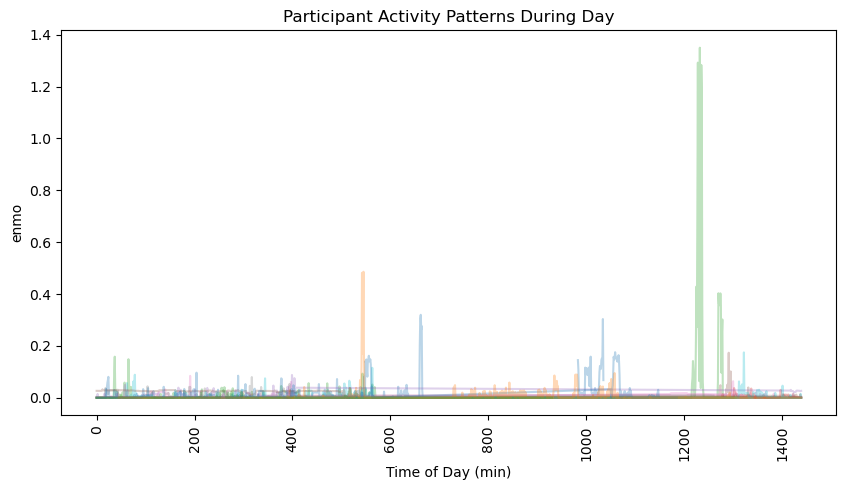

{'sendentary': 0.984951415174284,
 'light': 0.012485170329359923,
 'moderate': 0.0022597593356307555,
 'vigorous': 0.00030365516072538277}

In [5]:
pid = pids[2]

# function calls
df = read_parquet(pid)
df['formatted_time'] = df['time_of_day'].apply(format_time)
df = create_datetime_col(df)
plot_participant_activity(df)
get_activity_levels(df)

In [6]:
# what does non-wear flag data look like?
# should we filter it?
(df['non-wear_flag'] == 1).mean()

0.0

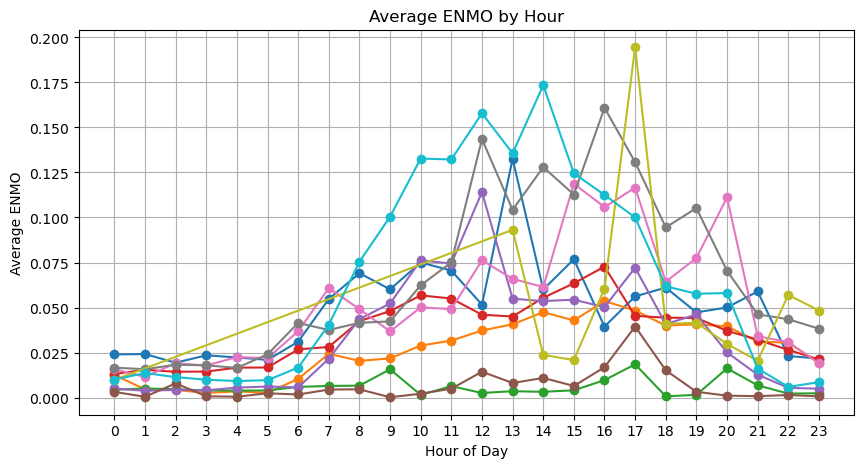

In [7]:
plt.figure(figsize=(10, 5))

for pid in pids[:10]:
    df = read_parquet(pid)
    df['formatted_time'] = df['time_of_day'].apply(format_time)
    df = create_datetime_col(df)
    df['hour'] = df['datetime'].dt.hour
    hourly_avg = df.groupby('hour')['enmo'].mean()
    plt.plot(hourly_avg, marker='o')
    
plt.xlabel('Hour of Day')
plt.ylabel('Average ENMO')
plt.title('Average ENMO by Hour')
plt.xticks(range(24))
plt.grid()
plt.show()

# compare someone with high and low sii?

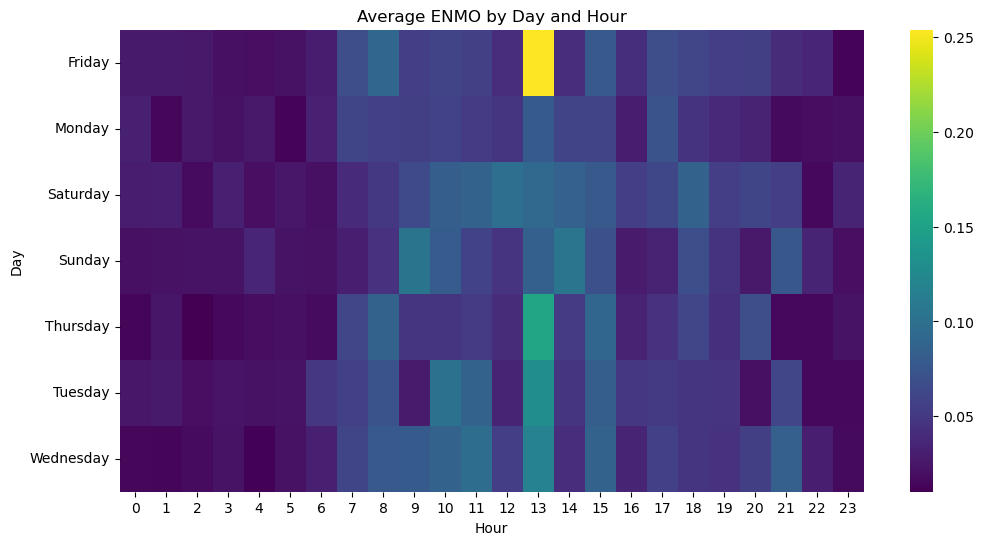

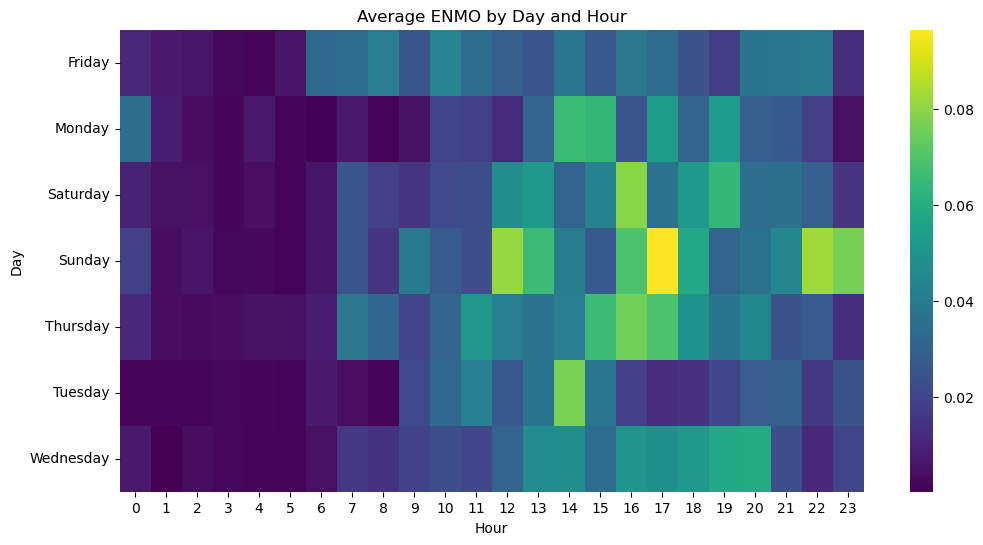

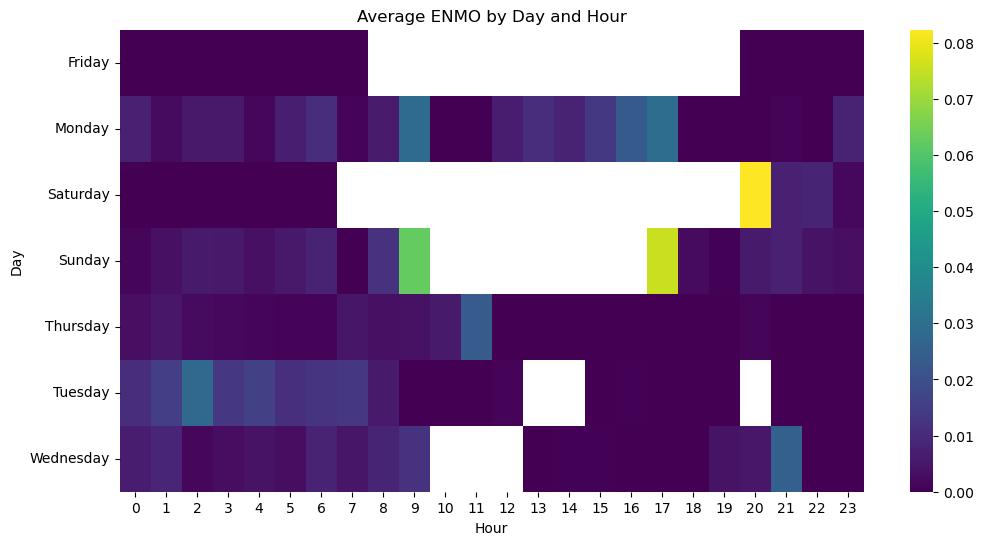

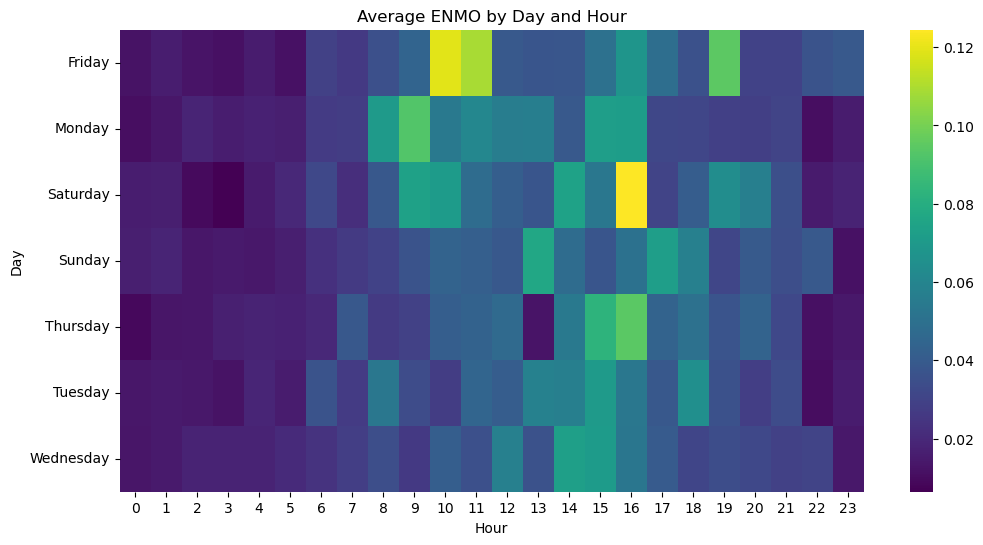

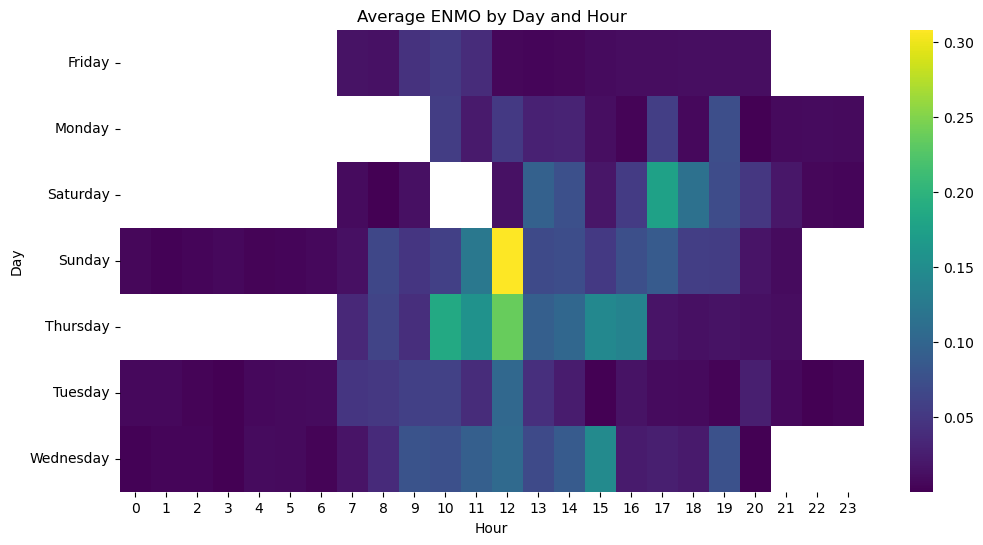

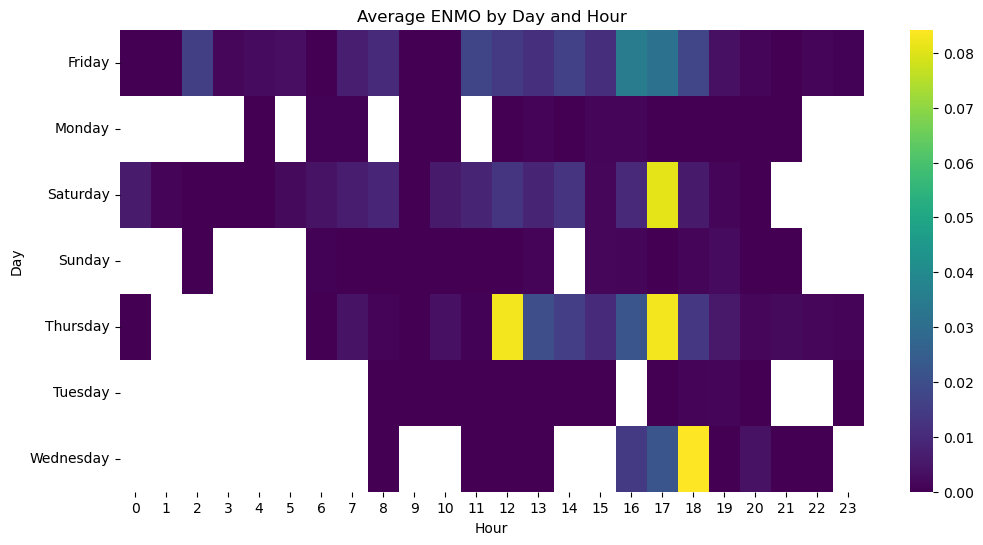

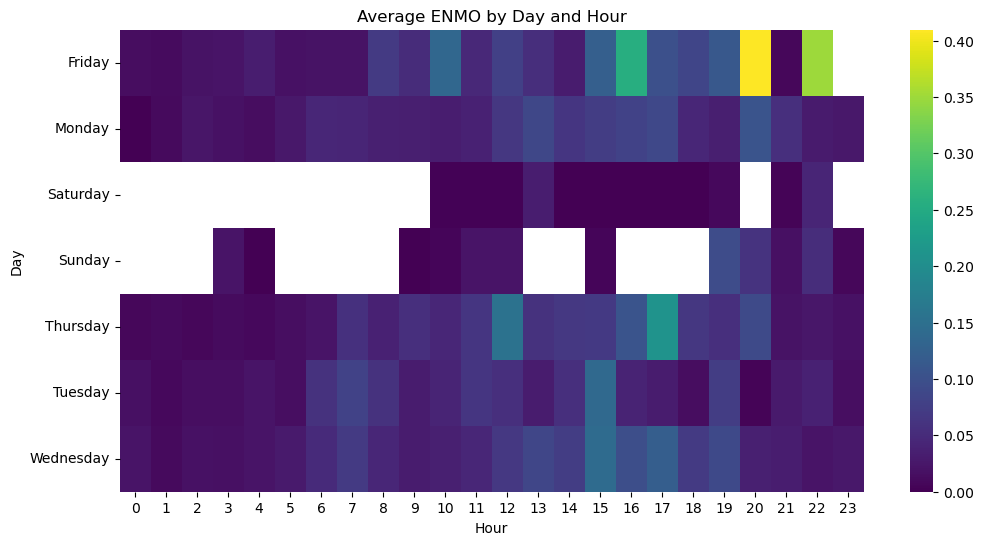

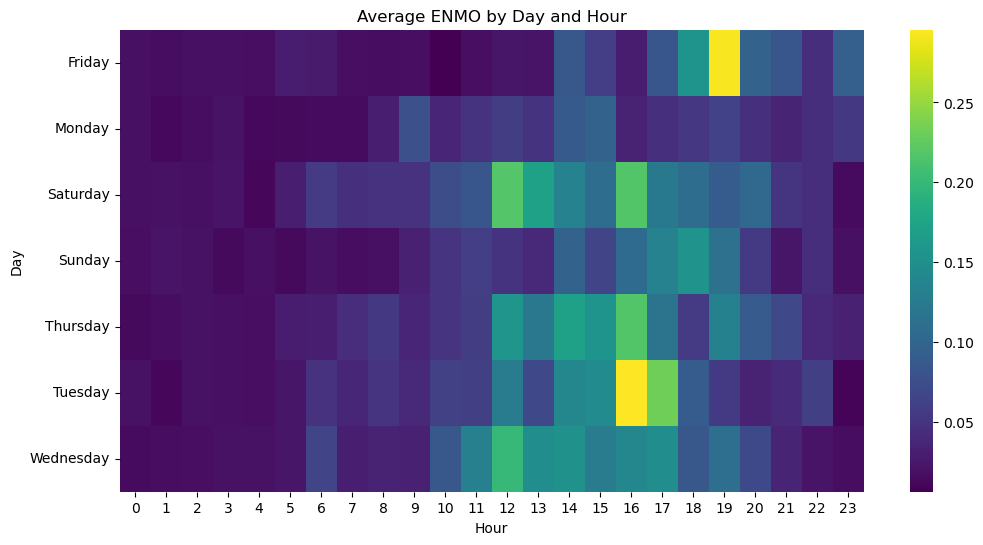

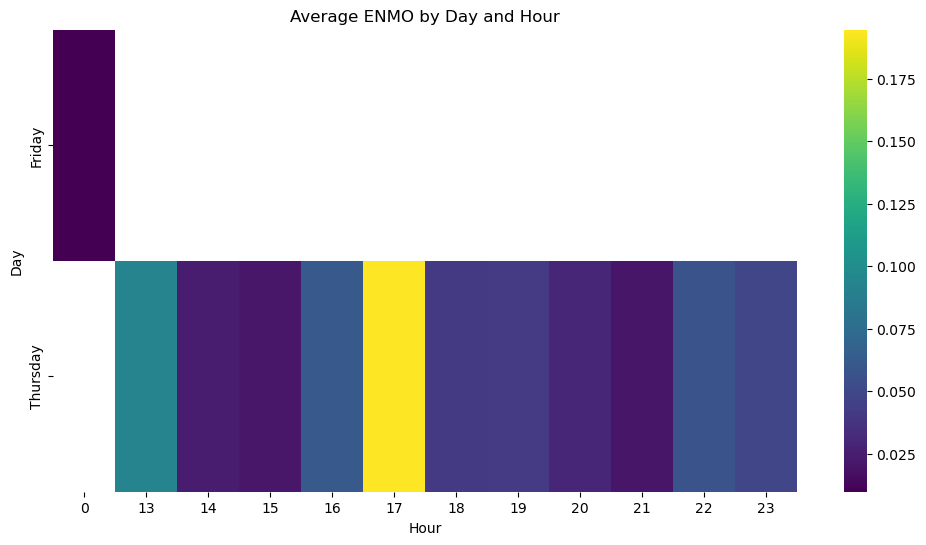

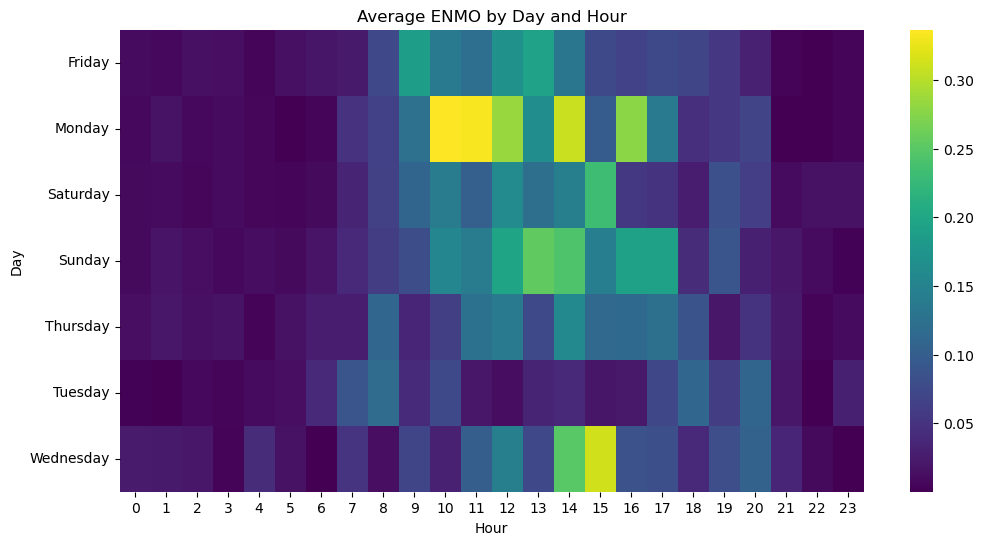

In [8]:
import seaborn as sns
import pandas as pd
for pid in pids[:10]:
    df = read_parquet(pid)
    df['formatted_time'] = df['time_of_day'].apply(format_time)
    df = create_datetime_col(df)
    df['hour'] = df['datetime'].dt.hour
    hourly_avg = df.groupby('hour')['enmo'].mean()
    df['day'] = df['datetime'].dt.day_name()
    hourly_day_avg = df.groupby(['day', 'hour'])['enmo'].mean().unstack()
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(hourly_day_avg, cmap='viridis', annot=False)
    plt.title('Average ENMO by Day and Hour')
    plt.xlabel('Hour')
    plt.ylabel('Day')
    plt.show()

# compare someone with high and low sii?

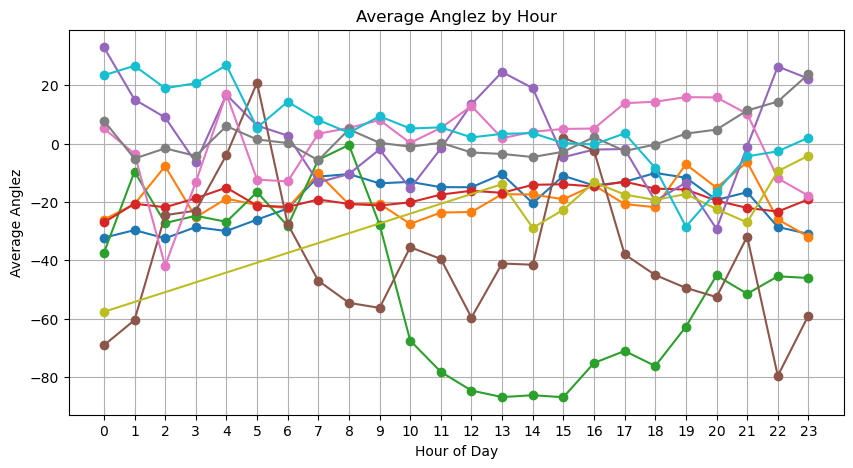

In [9]:
plt.figure(figsize=(10, 5))
for pid in pids[:10]:
    df = read_parquet(pid)
    df['formatted_time'] = df['time_of_day'].apply(format_time)
    df = create_datetime_col(df)
    df['hour'] = df['datetime'].dt.hour
    hourly_avg = df.groupby('hour')['anglez'].mean()
    plt.plot(hourly_avg, marker='o')

plt.xlabel('Hour of Day')
plt.ylabel('Average Anglez')
plt.title('Average Anglez by Hour')
plt.xticks(range(24))
plt.grid()
plt.show()

# compare someone with and without high sii?

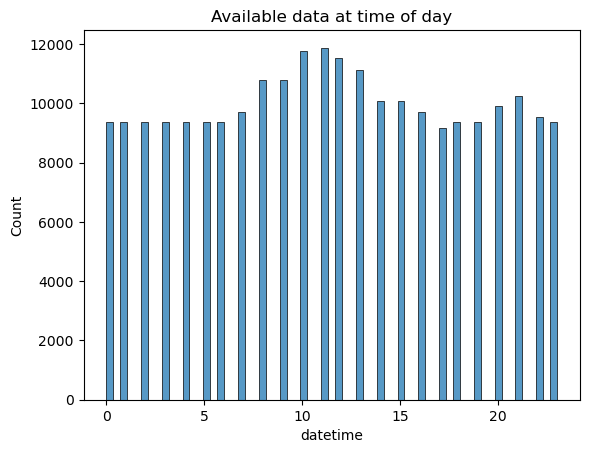

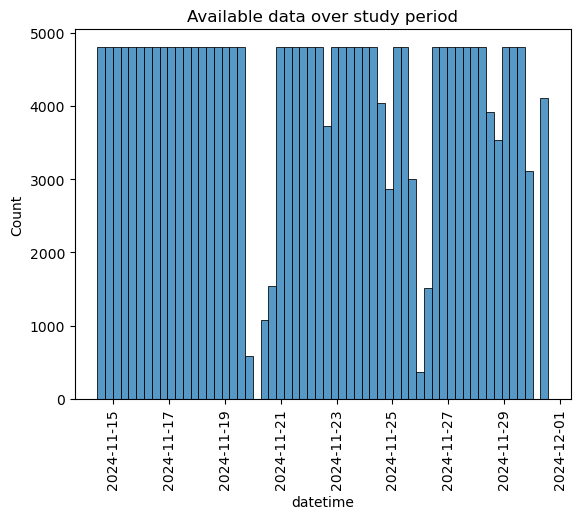

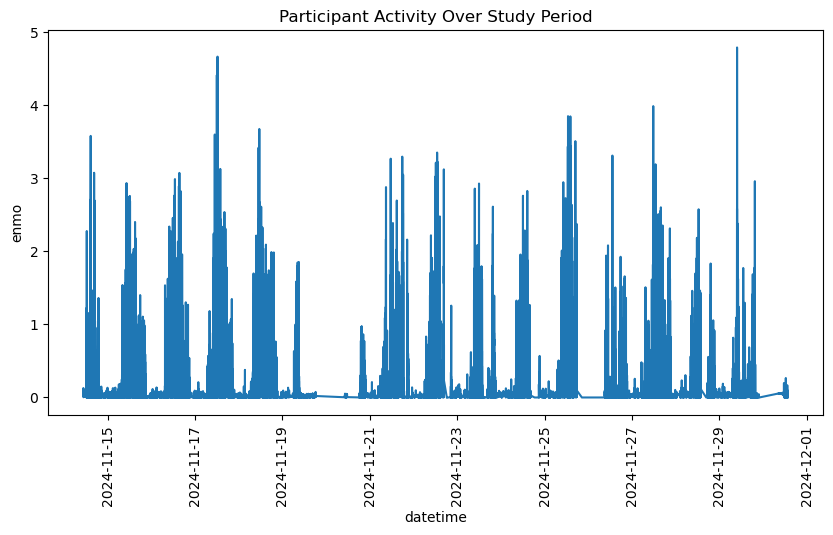

In [10]:
# alternative plots
# plot of data collection over hours
sns.histplot(df['datetime'].dt.hour)
plt.title('Available data at time of day')
plt.show()

# plot of data collection over study period
sns.histplot(df['datetime'])
plt.xticks(rotation=90)
plt.title('Available data over study period')
plt.show()

# plot of the actigraphy data over time
plt.figure(figsize=(10,5))
sns.lineplot(x=df['datetime'], y=df['enmo'])
plt.xticks(rotation=90)
plt.title('Participant Activity Over Study Period')
plt.show()

This shows the problem with `idle_sleep_mode1`. We have more data during the day than at night, so we probably can't do any sleep analysis. Furthermore, we may have missing data when a participant is sedentary, so we could be unerstating their sedentary time.

## All Participants

In [11]:
activity_level_list = []
for pid in tqdm(pids, desc="Processing pids", unit="pid"):
    df = read_parquet(pid)
    df['formatted_time'] = df['time_of_day'].apply(format_time)
    df = create_datetime_col(df)
    activity_level_list.append(get_activity_levels(df))

PA_data = pd.DataFrame(activity_level_list, index=pids)


Processing pids: 100%|█████████████████████| 996/996 [3:26:15<00:00, 12.43s/pid]


In [12]:
PA_data.to_csv('data/PA_data.csv')

In [25]:
PA_data = pd.read_csv('data/PA_data.csv', index_col=0)
PA_data = PA_data.rename(columns={'sendentary':'sedentary'})
PA_data

,sedentary,light,moderate,vigorous
0d01bbf2,0.701632,0.237437,0.054505,0.006427
cefdb7fe,0.843257,0.139514,0.016439,0.000790
58391429,0.984951,0.012485,0.002260,0.000304
2ca2206f,0.802400,0.153462,0.041454,0.002683
19455336,0.834869,0.115293,0.042899,0.006939
...,...,...,...,...
43a7386d,0.883229,0.079975,0.026972,0.009824
2840643b,0.688114,0.224201,0.079426,0.008258
1b329556,0.812550,0.135016,0.047040,0.005393
62b873a2,0.809303,0.129555,0.050563,0.010579


<Axes: xlabel='sedentary', ylabel='Count'>

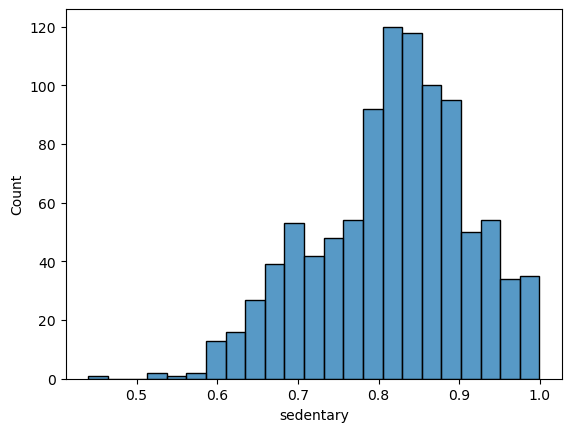

In [27]:
sns.histplot(PA_data['sedentary']) # whoops mispelled

<Axes: xlabel='light', ylabel='Count'>

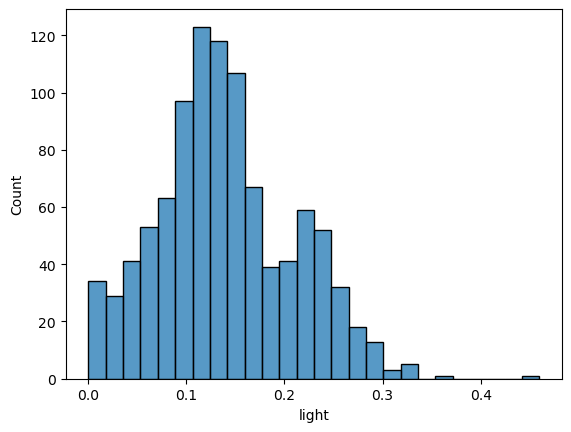

In [28]:
sns.histplot(PA_data['light'])

<Axes: xlabel='moderate', ylabel='Count'>

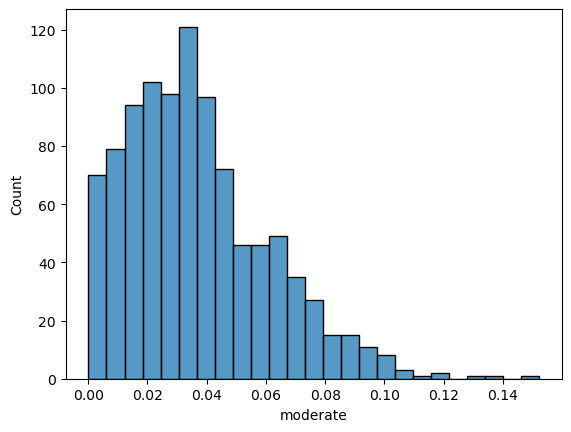

In [29]:
sns.histplot(PA_data['moderate'])

<Axes: xlabel='vigorous', ylabel='Count'>

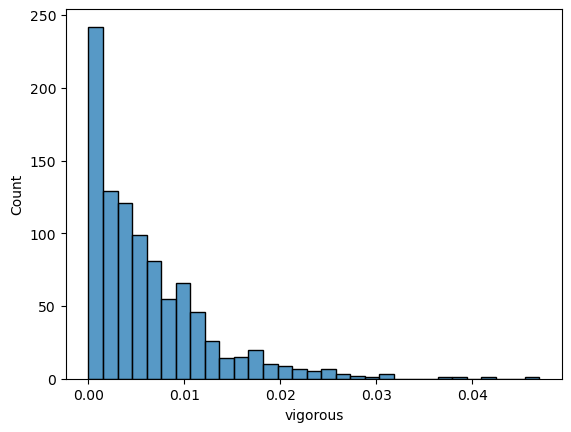

In [30]:
sns.histplot(PA_data['vigorous'])

## Test Dataset

In [18]:
base_dir = 'data/series_test.parquet'
subdirs = os.listdir(base_dir)
pids = [s.replace('id=', '') for s in subdirs]

In [19]:
print(len(pids))

2


In [20]:
activity_level_list = []
for pid in tqdm(pids, desc="Processing pids", unit="pid"):
    df = read_parquet(pid)
    df['formatted_time'] = df['time_of_day'].apply(format_time)
    df = create_datetime_col(df)
    activity_level_list.append(get_activity_levels(df))

PA_data = pd.DataFrame(activity_level_list, index=pids)

Processing pids: 100%|███████████████████████████| 2/2 [00:01<00:00,  1.82pid/s]


In [21]:
PA_data.to_csv('data/PA_data_test.csv')